
# End-to-End Data Product Analytics (Phyton)

This notebook walks through the full **data science lifecycle** using merger data of three CSVs:
- `customer.csv`
- `transactions.csv`
- `products.csv`

It includes:
- **Descriptive statistics** and **EDA**
- **Inferential statistics**
- **RFM segmentation**
- **Cohort analysis**
- **Prescriptive analytics (unsupervised): Customer Segmentation K-Means Clustring on RFM**
- **Predictive analytics (supervised): Customer Churn prediction**
- **Predictive analytics (supervised): Sales Forecasting**
- **Prescriptive analytics (unsupervised): Market Basket Analysis**



In [ ]:
!pip install -q mlxtend scikit-learn scipy pandas matplotlib


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option('display.max_columns', None)



## 1) Business Understanding

**Goal**: Deliver data-driven recommendations/insights for strategic decisions in **sales** and **product development**.

**Guiding Questions**
- Who are our high-value and at-risk customers?
- Which product combinations drive cross-sell opportunities?
- What early indicators signal **churn**?
- How do retention & behavior evolve over cohorts?

**Deliverables**
- Cleaned dataset joining **transactions + customers + products**
- Metrics & visuals for **descriptive/diagnostic analytics**
- **K-Means Clustering on RFM**
- **Customer Churn model** (probability & drivers)
- **Sales Forecasting (Prophet)**
- **Association rules** for product bundling (prescriptive insight)


## 2) Data Loading & Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CUSTOMER_CSV = '/content/customer.csv'
TRANSACTION_CSV = '/content/transactions.csv'
PRODUCT_CSV = '/content/product.csv'

# Load
customers = pd.read_csv(CUSTOMER_CSV)
transactions = pd.read_csv(TRANSACTION_CSV)
products = pd.read_csv(PRODUCT_CSV)

# Preview
print('customers:', customers.shape)
print('transactions:', transactions.shape)
print('products:', products.shape)
customers.head(), transactions.head(), products.head()


customers: (5647, 4)
transactions: (23053, 10)
products: (23, 4)


(   customer_Id         DOB Gender  city_code
 0       268408  02-01-1970      M        4.0
 1       269696  07-01-1970      F        8.0
 2       268159  08-01-1970      F        8.0
 3       270181  10-01-1970      F        2.0
 4       268073  11-01-1970      M        1.0,
    transaction_id  cust_id   tran_date  prod_subcat_code  prod_cat_code  Qty  \
 0     80712190438   270351  28-02-2014                 1              1   -5   
 1     29258453508   270384  27-02-2014                 5              3   -5   
 2     51750724947   273420  24-02-2014                 6              5   -2   
 3     93274880719   271509  24-02-2014                11              6   -3   
 4     51750724947   273420  23-02-2014                 6              5   -2   
 
    Rate      Tax  total_amt Store_type  
 0  -772  405.300  -4265.300     e-Shop  
 1 -1497  785.925  -8270.925     e-Shop  
 2  -791  166.110  -1748.110   TeleShop  
 3 -1363  429.345  -4518.345     e-Shop  
 4  -791  166.110  -1748.

In [ ]:
transactions['tran_date'] = pd.to_datetime(transactions['tran_date'], dayfirst=True, errors='coerce')

# Merge into a single dataset
df = transactions.merge(customers, left_on='cust_id', right_on='customer_Id', how='left') \
                 .merge(products, left_on=['prod_cat_code','prod_subcat_code'], right_on=['prod_cat_code','prod_sub_cat_code'], how='left')

# Drop the redundant customer_Id column from the merge
df.drop(columns=['customer_Id'], inplace=True)

# Sort by date for time-based features
df = df.sort_values('tran_date').reset_index(drop=True)

print('Merged df:', df.shape)
df.head()

Merged df: (23053, 16)


,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,DOB,Gender,city_code,prod_cat,prod_sub_cat_code,prod_subcat
0,77960931771,271961,2011-01-25,11,5,1,447,46.935,493.935,TeleShop,15-01-1982,M,1.0,Books,11,Children
1,32887353269,268885,2011-01-25,3,1,1,276,28.980,304.980,Flagship store,14-04-1989,F,6.0,Clothing,3,Kids
2,28972634039,275227,2011-01-25,9,3,1,334,35.070,369.070,MBR,23-09-1989,M,4.0,Electronics,9,Cameras
3,42161597232,267094,2011-01-25,3,1,3,147,46.305,487.305,MBR,24-11-1992,M,9.0,Clothing,3,Kids
4,46821751538,269160,2011-01-25,10,5,5,941,494.025,5199.025,TeleShop,24-01-1972,F,1.0,Books,10,Non-Fiction


In [ ]:

# Overall KPIs
total_revenue = df['total_amt'].sum()
unique_customers = df['cust_id'].nunique()
unique_transactions = df['transaction_id'].nunique()

print(f'Total revenue: {total_revenue:,.2f}')
print(f'Unique customers: {unique_customers:,}')
print(f'Unique transactions: {unique_transactions:,}')

# Descriptives for key numeric columns
numeric_cols = ['Qty','Rate','Tax','total_amt']
desc_stats = df[numeric_cols].describe().T
desc_stats


Total revenue: 48,579,771.37
Unique customers: 5,506
Unique transactions: 20,878


,count,mean,std,min,25%,50%,75%,max
Qty,23053.0,2.432395,2.268406,-5.000,1.00,3.00,4.000,5.0
Rate,23053.0,636.369713,622.363498,-1499.000,312.00,710.00,1109.000,1500.0
Tax,23053.0,248.667192,187.177773,7.350,98.28,199.08,365.715,787.5
total_amt,23053.0,2107.308002,2507.561264,-8270.925,762.45,1754.74,3569.150,8287.5


## 3) Exploratory Data Analysis (EDA)

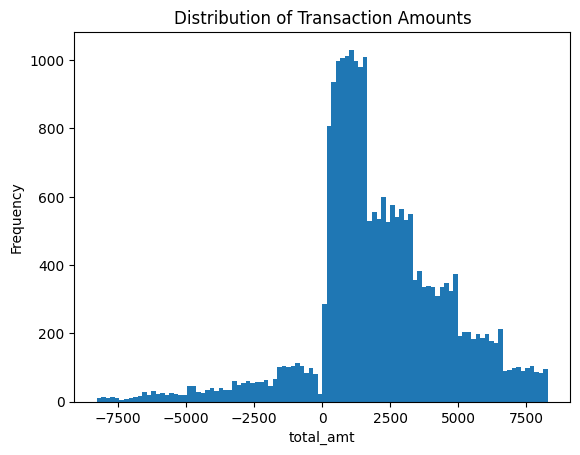

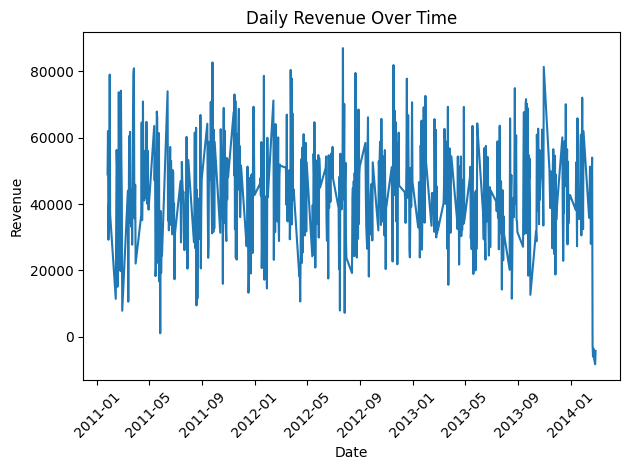

In [ ]:
# Revenue distribution
plt.figure()
df['total_amt'].plot(kind='hist', bins=100, title='Distribution of Transaction Amounts')
plt.xlabel('total_amt')
plt.show()

# Daily revenue trend
daily = df.groupby(df['tran_date'].dt.date)['total_amt'].sum().reset_index()
plt.figure()
plt.plot(daily['tran_date'], daily['total_amt'])
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Distribution of Transaction Amounts:**

The histogram shows a large concentration of transaction amounts in the positive range, which represents sales. There's also a noticeable, smaller cluster of transactions with negative amounts. These negative values likely represent returns or refunds. The distribution of positive amounts seems skewed, with a tail extending towards higher values.

Daily Revenue Over Time: The line plot displays the total revenue for each day. We can see a fluctuating pattern without a very strong long-term upward or downward trend over the observed period. There are noticeable daily or weekly variations, but it's hard to discern clear long-term seasonality or strong trends just from this plot. There are periods with higher peaks and lower troughs in daily revenue.

## 4) Inferential Statistics (Hypothesis Test Example)

In [ ]:

group_col = 'Gender' if 'Gender' in df.columns else None
if group_col:
    groups = df[[group_col,'total_amt']].dropna()
    levels = groups[group_col].unique()
    if len(levels) >= 2:
        g1 = groups[groups[group_col] == levels[0]]['total_amt']
        g2 = groups[groups[group_col] == levels[1]]['total_amt']
        t_stat, p_val = ttest_ind(g1, g2, equal_var=False, nan_policy='omit')
        print(f"T-test between {levels[0]} and {levels[1]}: t={t_stat:.3f}, p={p_val:.4f}")
    else:
        print('Not enough groups to run t-test.')
else:
    print('Column `gender` not found; skip t-test example.')


T-test between M and F: t=0.247, p=0.8047


**T-test:**

The output T-test between M and F: t=0.247, p=0.8047 means:

t=0.247: This is the calculated t-statistic.
It measures the difference between the two group means relative to the variability within the groups. A value close to zero suggests little difference between the means.

p=0.8047: This is the p-value. It represents the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated from your data, assuming there is no real difference in the average transaction amounts between the two genders (the null hypothesis).

Since the p-value (0.8047) is much greater than the typical significance level of 0.05, we fail to reject the null hypothesis. In simpler terms, based on this data and this test, there is no statistically significant difference in the average transaction amount between male and female customers.

## 5) RFM Segmentation

In [ ]:
#day after the last transaction
snapshot_date = df['tran_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('cust_id').agg(
    Recency=('tran_date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('transaction_id','nunique'),
    Monetary=('total_amt','sum')
).reset_index()

# Drop rows with NaN Recency (customers with no transactions)
rfm.dropna(subset=['Recency'], inplace=True)


# Simple scoring: 1 (low) - 5 (high) per metric
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)  # lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

# Basic segment mapping
def segment_map(score):
    if score >= 12 and score <= 15:
        return 'VIP'
    elif score >= 9 and score <= 11:
        return 'Loyal'
    elif score >= 6 and score <= 8:
        return 'At Risk'
    else:
        return 'Dormant'


rfm['Segment'] = rfm['RFM_Score'].apply(segment_map)
rfm.head()


rfm.to_csv('rfm.csv', index=False)

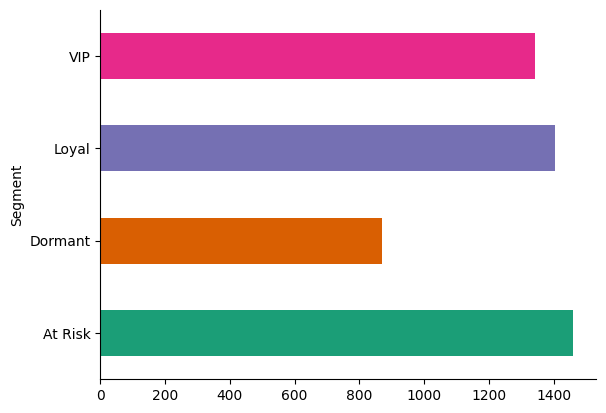

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
rfm.groupby('Segment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

**RFM segments (Simple Scoring)**

*   **At Risk** is the largest segment → These are customers who haven't purchased recently (high Recency, lower Recency score) but might have had good Frequency or Monetary scores. They are at risk of churning.
*   **Loyal** is the second largest segment → These customers have good Recency, Frequency, and Monetary scores, indicating they are valuable and repeat buyers.
*   **VIP** is also a significant segment → These are most valuable customers with the highest Recency, Frequency, and Monetary scores.
*   **Dormant** is the smallest segment → These customers have low RFM scores across the board, indicating they haven't purchased recently and might not have been highly engaged in the past.

The bar chart visually represents the number of customers in each of these four segments based on the simple scoring method.

## 6) Cohort Analysis (Retention)

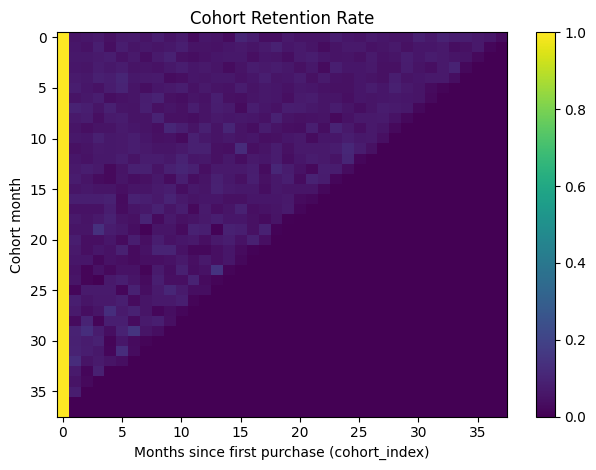

cohort_index,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0
cohort_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,1.0,0.052,0.059,0.067,0.044,0.067,0.074,0.052,0.081,0.052,0.074,0.030,0.059,0.052,0.030,0.104,0.081,0.037,0.037,0.067,0.052,0.052,0.052,0.081,0.059,0.052,0.074,0.059,0.052,0.052,0.089,0.067,0.096,0.081,0.081,0.067,0.059,0.03
2011-02-01,1.0,0.060,0.049,0.084,0.039,0.081,0.056,0.063,0.056,0.063,0.084,0.053,0.053,0.049,0.060,0.067,0.056,0.074,0.091,0.060,0.074,0.056,0.032,0.053,0.067,0.070,0.049,0.056,0.067,0.046,0.060,0.060,0.067,0.039,0.046,0.067,0.018,0.00
2011-03-01,1.0,0.065,0.062,0.071,0.080,0.051,0.068,0.039,0.071,0.092,0.045,0.036,0.048,0.060,0.065,0.062,0.042,0.060,0.057,0.039,0.071,0.080,0.060,0.054,0.057,0.045,0.071,0.048,0.057,0.080,0.060,0.077,0.068,0.057,0.054,0.027,0.000,0.00
2011-04-01,1.0,0.061,0.058,0.075,0.064,0.078,0.051,0.058,0.047,0.064,0.081,0.061,0.068,0.058,0.034,0.051,0.078,0.068,0.075,0.064,0.044,0.064,0.031,0.085,0.061,0.061,0.068,0.044,0.044,0.078,0.051,0.041,0.068,0.095,0.020,0.000,0.000,0.00
2011-05-01,1.0,0.073,0.065,0.089,0.081,0.102,0.065,0.069,0.073,0.033,0.041,0.061,0.057,0.065,0.065,0.049,0.061,0.085,0.057,0.061,0.077,0.045,0.073,0.049,0.045,0.061,0.053,0.045,0.081,0.053,0.061,0.069,0.069,0.037,0.000,0.000,0.000,0.00
2011-06-01,1.0,0.081,0.060,0.048,0.077,0.101,0.056,0.036,0.060,0.069,0.081,0.048,0.069,0.052,0.048,0.077,0.052,0.065,0.060,0.048,0.065,0.060,0.048,0.044,0.044,0.060,0.077,0.060,0.089,0.069,0.056,0.028,0.012,0.000,0.000,0.000,0.000,0.00
2011-07-01,1.0,0.051,0.063,0.078,0.035,0.047,0.055,0.078,0.094,0.043,0.035,0.055,0.047,0.082,0.043,0.039,0.055,0.063,0.059,0.039,0.071,0.075,0.055,0.055,0.039,0.059,0.055,0.059,0.063,0.059,0.055,0.024,0.000,0.000,0.000,0.000,0.000,0.00
2011-08-01,1.0,0.097,0.084,0.057,0.088,0.057,0.053,0.084,0.044,0.057,0.044,0.079,0.053,0.079,0.070,0.031,0.079,0.062,0.048,0.079,0.075,0.066,0.057,0.075,0.057,0.035,0.057,0.075,0.070,0.066,0.022,0.000,0.000,0.000,0.000,0.000,0.000,0.00
2011-09-01,1.0,0.068,0.077,0.041,0.073,0.077,0.055,0.055,0.095,0.045,0.045,0.036,0.055,0.068,0.059,0.064,0.059,0.050,0.091,0.055,0.045,0.050,0.055,0.027,0.050,0.068,0.068,0.073,0.050,0.023,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00


In [ ]:
# 1) Transform data type tran_date
df['order_month']  = df['tran_date'].values.astype('datetime64[M]')

# 2) Cohort = search for first month of purchase customer
first_month = df.groupby('cust_id')['order_month'].min()
df['cohort_month'] = df['cust_id'].map(first_month)


# 3) Cohort index
df['cohort_index'] = (
    (df['order_month'].dt.year - df['cohort_month'].dt.year) * 12 +
    (df['order_month'].dt.month - df['cohort_month'].dt.month)
)

# 4) unique customer cohort
cohort_cnt = (df
    .groupby(['cohort_month','cohort_index'])['cust_id']
    .nunique()
    .unstack(fill_value=0)
)

# 5) Retention
cohort_size = cohort_cnt.iloc[:, 0].replace(0, 1)
cohort_ret = cohort_cnt.divide(cohort_size, axis=0)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cohort_ret, aspect='auto', interpolation='nearest')
plt.title('Cohort Retention Rate')
plt.xlabel('Months since first purchase (cohort_index)')
plt.ylabel('Cohort month')
plt.colorbar()
plt.tight_layout()
plt.show()

cohort_ret.round(3)

**Cohort retention**

Customer retention drops sharply after the first 1-3 months, indicating most new customers do not make repeat purchases in subsequent months.

## 7) Unsupervised Learning – Customer Segmentation (K-Means on RFM)

             customers  Recency_mean  Frequency_mean  Monetary_mean
ClusterName                                                        
Champions         1940        414.84            5.04       12292.16
Loyal             1280         71.85            4.74       10885.18
Promising         1782        537.41            2.28        4963.75
Dormant             73        458.05            1.77        -958.63
Saved rfm_clusters_k4_named.csv


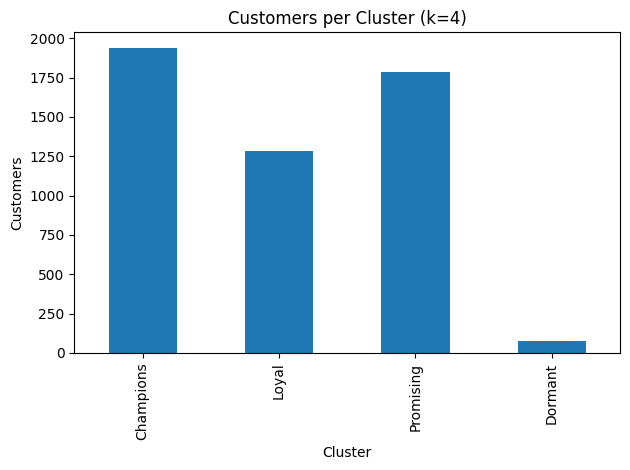

In [ ]:
# K-Means based on RFM
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1) Log transform
X_raw = rfm[['Recency','Frequency','Monetary']].astype(float).copy()
# Replace negative monetary values with 0 before log transform
X_raw['Monetary'] = X_raw['Monetary'].apply(lambda x: max(x, 0))

X_log = np.log1p(X_raw)

# 2) Scaling
scaler_km = StandardScaler()
Xz = scaler_km.fit_transform(X_log)

# 3) K-Means k=4
kmeans4 = KMeans(n_clusters=4, random_state=42, n_init=50)
rfm['ClusterID'] = kmeans4.fit_predict(Xz)

# 4) Cluster RFM
prof = rfm.groupby('ClusterID')[['Recency','Frequency','Monetary']].mean()

prof['R_rank'] = prof['Recency'].rank(ascending=True,  method='first')
prof['F_rank'] = prof['Frequency'].rank(ascending=False, method='first')
prof['M_rank'] = prof['Monetary'].rank(ascending=False, method='first')
prof['score']  = prof[['R_rank','F_rank','M_rank']].sum(axis=1)

order = prof.sort_values(['score','R_rank','F_rank','M_rank']).index.tolist()
label_order = ['Champions','Loyal','Promising','Dormant']
name_map = {cid: label_order[i] for i, cid in enumerate(order)}
rfm['ClusterName'] = rfm['ClusterID'].map(name_map)

summary = (rfm.groupby('ClusterName')
             .agg(customers=('cust_id','nunique'),
                  Recency_mean=('Recency','mean'),
                  Frequency_mean=('Frequency','mean'),
                  Monetary_mean=('Monetary','mean'))
             .reindex(label_order))
print(summary.round(2))

rfm[['cust_id','Recency','Frequency','Monetary','ClusterName']].to_csv(
    'rfm_clusters_k4_named.csv', index=False)
print('Saved rfm_clusters_k4_named.csv')

import matplotlib.pyplot as plt
counts = rfm['ClusterName'].value_counts().reindex(label_order)
plt.figure()
counts.plot(kind='bar')
plt.title('Customers per Cluster (k=4)')
plt.xlabel('Cluster'); plt.ylabel('Customers'); plt.tight_layout(); plt.show()

**RFM K-Means Clustering:**

 K-Means clustering was applied to the RFM metrics to segment customers into 4 distinct groups, labeled as 'Champions', 'Loyal', 'Promising', and 'Dormant'.

 These segments are profiled based on their average Recency, Frequency, and Monetary values.

- The 'Champions' are the most valuable group (high F & M, reasonable R)
- 'Loyal' have good RFM scores across the board (especially low R)
- 'Promising' are newer or less frequent buyers (high R)
- 'Dormant' have low activity.

This segmentation provides actionable groups for targeted marketing strategies.

## 8) Predictive Analytics (Supervised) – Churn Prediction

In [ ]:
# Churn modeling
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, confusion_matrix

PRED_WINDOW_DAYS = 90

# 1) Cutoff waktu (anti-leakage)
last_date = df['tran_date'].max()
cut_date  = last_date - pd.Timedelta(days=PRED_WINDOW_DAYS)

# 2) HISTORI (<= cut_date)
hist = df[df['tran_date'] <= cut_date].copy().sort_values(['cust_id','tran_date'])
hist['prev_date']      = hist.groupby('cust_id')['tran_date'].shift(1)
hist['days_since_prev']= (hist['tran_date'] - hist['prev_date']).dt.days

feat = hist.groupby('cust_id').agg(
    Recency   =('tran_date', lambda x: (cut_date - x.max()).days if x.notna().any() else 9999),
    Frequency =('transaction_id','nunique'),
    Monetary  =('total_amt','sum'),
    AvgBasket =('total_amt','mean'),
    DaysMean  =('days_since_prev','mean'),
    DaysStd   =('days_since_prev','std'),
    CatDivers =('prod_cat','nunique'),
    SubcatDivers=('prod_subcat','nunique')
).reset_index().fillna(0)

# proporsi belanja per Store_type (opsional tapi bagus)
store_piv  = hist.pivot_table(index='cust_id', columns='Store_type', values='total_amt', aggfunc='sum', fill_value=0)
store_prop = store_piv.div(store_piv.sum(axis=1).replace(0,1), axis=0)
store_prop.columns = [f'prop_store_{c}' for c in store_prop.columns]
feat = feat.merge(store_prop.reset_index(), on='cust_id', how='left').fillna(0)

# 3) LABEL dari MASA DEPAN (cut_date -> cut_date+window)
future   = df[(df['tran_date'] > cut_date) & (df['tran_date'] <= cut_date + pd.Timedelta(days=PRED_WINDOW_DAYS))]
will_buy = future.groupby('cust_id')['transaction_id'].nunique().gt(0)  # True kalau beli lagi
feat['Churn'] = (~feat[['cust_id']].merge(will_buy.rename('buy'), on='cust_id', how='left')['buy'].fillna(False)).astype(int)

# 4) JOIN cluster yang SUDAH ADA (tidak membuat ulang)
try:
    clusters = rfm[['cust_id','ClusterName']].drop_duplicates()
except NameError:
    clusters = pd.read_csv('rfm_clusters_k4_named.csv')[['cust_id','ClusterName']].drop_duplicates()

feat = feat.merge(clusters, on='cust_id', how='left')
feat['ClusterName'] = feat['ClusterName'].fillna('Unknown')     # jaga-jaga
cluster_dum = pd.get_dummies(feat['ClusterName'], prefix='cl')  # one-hot utk model
feat = pd.concat([feat.drop(columns=['ClusterName']), cluster_dum], axis=1)

# 5) Train/test + scaling (numeric saja) + model
y = feat['Churn'].astype(int)
X = feat.drop(columns=['cust_id','Churn'])
num_cols = [c for c in X.columns if not c.startswith('cl_')]
dum_cols = [c for c in X.columns if c.startswith('cl_')]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

sc = StandardScaler()
X_tr_s = X_tr.copy(); X_te_s = X_te.copy()
X_tr_s[num_cols] = sc.fit_transform(X_tr[num_cols])
X_te_s[num_cols] = sc.transform(X_te[num_cols])

clf = LogisticRegression(max_iter=2000, class_weight='balanced')
clf.fit(X_tr_s, y_tr)

# 6) PROB + pilih threshold yang masuk akal (hindari "semua = 1")
p = clf.predict_proba(X_te_s)[:,1]
print('ROC AUC:', roc_auc_score(y_te, p))

# Pilih threshold by F1 (alternatif lain: Youden J / Top-K)
prec, rec, thr = precision_recall_curve(y_te, p)
f1 = 2*prec*rec/(prec+rec+1e-9)
t  = thr[f1[:-1].argmax()]
y_hat = (p >= t).astype(int)

print('Threshold used (F1-optimal):', round(float(t),3))
print('Confusion matrix:\\n', confusion_matrix(y_te, y_hat))
print(classification_report(y_te, y_hat))

# 7) Skor SEMUA customer + decile
X_all = X.copy()
X_all[num_cols] = sc.transform(X_all[num_cols])
feat['p_churn'] = clf.predict_proba(X_all)[:,1]
feat['decile']  = pd.qcut(feat['p_churn'].rank(method='first'), 10, labels=False) + 1

cl_cols = [c for c in feat.columns if c.startswith('cl_')]
feat['ClusterName'] = [cl_cols[i].replace('cl_','') for i in np.argmax(feat[cl_cols].values, axis=1)]

cols_out = ['cust_id','p_churn','decile','ClusterName','Recency','Frequency','Monetary','AvgBasket',
            'DaysMean','DaysStd','CatDivers','SubcatDivers'] + cl_cols
feat[cols_out].to_csv('churn_scores_for_BI.csv', index=False)
print('Saved churn_scores_for_BI.csv')

ROC AUC: 0.9883137712327767
Threshold used (F1-optimal): 0.23
Confusion matrix:\n [[ 179   36]
 [  14 1262]]
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       215
           1       0.97      0.99      0.98      1276

    accuracy                           0.97      1491
   macro avg       0.95      0.91      0.93      1491
weighted avg       0.97      0.97      0.97      1491

Saved churn_scores_for_BI.csv


/tmp/ipython-input-1841099559.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feat['Churn'] = (~feat[['cust_id']].merge(will_buy.rename('buy'), on='cust_id', how='left')['buy'].fillna(False)).astype(int)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:451: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  opt_res = optimize.minimize(


**Customer Churn Prediction:**

A Logistic Regression model accurately predicts customer churn (ROC AUC 0.988) based on historical data, enabling the identification of high-risk customers for retention efforts.

## 9) Predictive Analytics – Sales Forecasting

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxsfa9pe3/n9x8w2xp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxsfa9pe3/4qfyl7tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87357', 'data', 'file=/tmp/tmpxsfa9pe3/n9x8w2xp.json', 'init=/tmp/tmpxsfa9pe3/4qfyl7tl.json', 'output', 'file=/tmp/tmpxsfa9pe3/prophet_model1_e4e0hl/prophet_model-20250815052014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2011-01-25,44681.021026,27169.741105,63355.768021
1,2011-01-26,46227.223373,28624.681914,64211.052124
2,2011-01-27,46410.224003,26886.319670,64762.084014
3,2011-01-28,44713.320496,26675.147154,63024.257596
4,2011-01-29,48629.651554,30003.702381,66742.345159


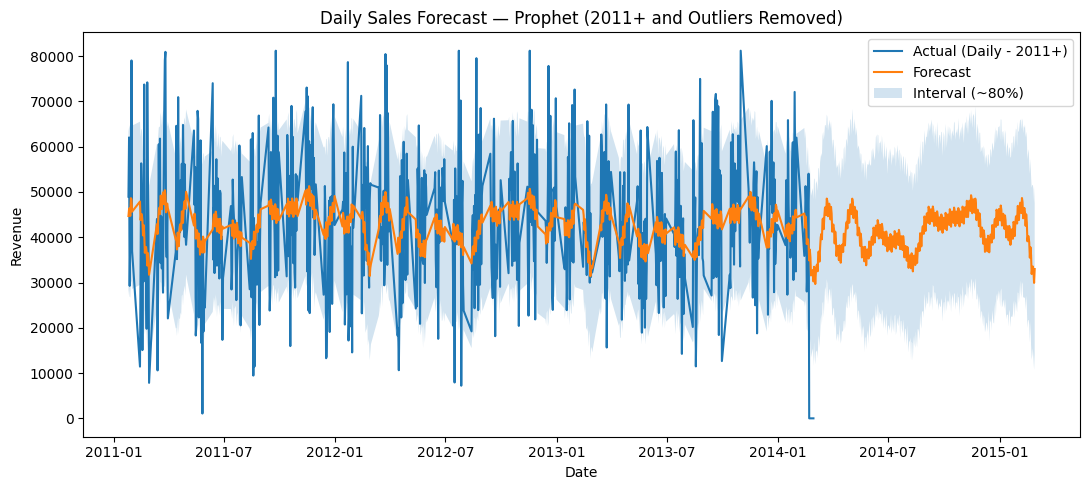

Saved: sales_forecast_weekly_prophet.csv


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

prophet_data = daily.reset_index().rename(columns={'tran_date': 'ds', 'total_amt': 'y'})

# Convert 'ds' to datetime
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

# Filter data from the year 2011 onwards
prophet_data = prophet_data[prophet_data['ds'].dt.year >= 2011].copy()

# Remove outliers by clipping (using 99.5th percentile as upper bound)
cap = prophet_data['y'].quantile(0.995)
prophet_data['y'] = prophet_data['y'].clip(lower=0, upper=cap)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Make a future dataframe for forecasting
future = model.make_future_dataframe(periods=365) # Forecast for 365 days

# Make predictions
forecast = model.predict(future)

# Display the first few rows of the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# Plot histori + forecast + interval
plt.figure(figsize=(11,5))
# Plot the actual data used for training (after filtering and clipping)
plt.plot(prophet_data['ds'], prophet_data['y'], label='Actual (Daily - 2011+)')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 alpha=0.2, label='Interval (~80%)')
plt.title('Daily Sales Forecast — Prophet (2011+ and Outliers Removed)')
plt.xlabel('Date'); plt.ylabel('Revenue')
plt.legend(); plt.tight_layout(); plt.show()


forecast.to_csv('sales_forecast_weekly_prophet.csv', index=False)
print('Saved: sales_forecast_weekly_prophet.csv')

In [ ]:
# Select relevant columns from actual data
actual_data_for_bi = prophet_data[['ds', 'y']].copy()
actual_data_for_bi.rename(columns={'y': 'Actual_Revenue'}, inplace=True)
actual_data_for_bi['Type'] = 'Actual'


# Select relevant columns from forecast data
forecast_data_for_bi = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_data_for_bi.rename(columns={'yhat': 'Forecast_Revenue',
                                     'yhat_lower': 'Forecast_Lower',
                                     'yhat_upper': 'Forecast_Upper'}, inplace=True)
forecast_data_for_bi['Type'] = 'Forecast'


# Merge actual and forecast dataframes based on date
# Use a common date range if needed, here we'll include all dates from both
combined_data_for_bi = pd.merge(actual_data_for_bi, forecast_data_for_bi, on='ds', how='outer')

# Export the combined data to a CSV file
combined_data_for_bi.to_csv('sales_forecast_for_power_bi.csv', index=False)

print("Saved 'sales_forecast_for_power_bi.csv' for Power BI visualization.")

Saved 'sales_forecast_for_power_bi.csv' for Power BI visualization.


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge actual and predicted values for evaluation
evaluation_df = prophet_data.merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Drop rows with missing values (dates in forecast but not in actual data)
evaluation_df.dropna(inplace=True)

# Calculate accuracy metrics
mae = mean_absolute_error(evaluation_df['y'], evaluation_df['yhat'])
rmse = np.sqrt(mean_squared_error(evaluation_df['y'], evaluation_df['yhat']))
mape = np.mean(np.abs((evaluation_df['y'] - evaluation_df['yhat']) / evaluation_df['y'])) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 11509.00
Root Mean Squared Error (RMSE): 14484.96


**Sales Forecasting Results:**

- **Model Used:** The Prophet model was used to forecast daily sales revenue.
- **Data Preparation:** Daily revenue data from 2011 onwards was used for training. Outliers were removed by clipping the data at the 99.5th percentile.
- **Forecast Period:** The model generated a forecast for 365 days into the future.
- **Evaluation Metrics:**
    - Mean Absolute Error (MAE): 11509.00
    - Root Mean Squared Error (RMSE): 14484.96

The forecast shows a general trend with predicted daily revenue values and an associated uncertainty interval. The calculated metrics (MAE and RMSE) provide an indication of the model's accuracy on the historical data.

## 10) Prescriptive Analytics (Unsupervised) – Market Basket Analysis

In [ ]:
# --- Robust Market Basket: auto-diagnose & adaptive thresholds ---
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import numpy as np

# 0) Pilih granularitas item yang tersedia
gran_candidates = ['prod_cat', 'prod_subcat_code', 'prod_cat_code', 'product_name']
item_col = next((c for c in gran_candidates if c in df.columns), None)
assert item_col is not None, f"Tidak menemukan kolom produk. Coba salah satu dari: {gran_candidates}"

qty_col = 'Qty' if 'Qty' in df.columns else next((c for c in df.columns if c.lower()=='qty'), None)
assert qty_col is not None, "Kolom Qty tidak ditemukan."

# 1) Basket 0/1
basket = (df.groupby(['transaction_id', item_col])[qty_col]
            .sum().unstack(fill_value=0))
basket_bin = (basket > 0).astype('int')

# 2) Diagnostik dasar
n_tx   = basket_bin.shape[0]
n_item = basket_bin.shape[1]
multi_ratio = (basket_bin.sum(axis=1) >= 2).mean()

print(f"Tx: {n_tx:,} | Items: {n_item:,} | % Multi-item tx: {multi_ratio:.2%}")

if multi_ratio < 0.02:
    print("Hampir semua transaksi 1 item → rules sangat sedikit. "
          "Pertimbangkan pakai granularitas lebih kasar (prod_cat) atau turunkan ambang drastis.")

# 3) Cari rules dengan ambang adaptif
minsup_list = [0.02, 0.01, 0.005, 0.002, max(0.001, 2/n_tx)]
conf_list   = [0.35, 0.25, 0.15, 0.10]
lift_min    = 1.01

rules_sorted = pd.DataFrame()
for ms in minsup_list:
    freq = apriori(basket_bin, min_support=ms, use_colnames=True, max_len=2)
    if freq.empty:
        continue
    rules = association_rules(freq, metric='lift', min_threshold=lift_min)
    for cf in conf_list:
        rules_f = rules[(rules['confidence']>=cf) & (rules['lift']>=lift_min)].copy()
        if not rules_f.empty:
            rules_sorted = rules_f.sort_values(['lift','confidence','support'], ascending=False)
            print(f"Dapat {len(rules_sorted)} rules @ min_support={ms}, confidence>={cf}, lift>={lift_min}")
            break
    if not rules_sorted.empty:
        break

if rules_sorted.empty:
    print("Tidak ada rules yang lolos meski ambang sudah longgar. "
          "Kemungkinan transaksi multi-item terlalu sedikit atau granularitas terlalu halus.")
else:
    # 4) Kolom ramah bisnis + Top-3 per antecedent
    rules_sorted['antecedent'] = rules_sorted['antecedents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules_sorted['consequent'] = rules_sorted['consequents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules_sorted['rule']       = rules_sorted['antecedent'] + ' → ' + rules_sorted['consequent']
    rules_sorted['lift_gain']  = rules_sorted['lift'] - 1
    rules_sorted['coverage']   = rules_sorted['antecedent_support']
    rules_sorted = rules_sorted.drop_duplicates(subset=['rule'])

    topN = (rules_sorted
            .sort_values(['antecedent','lift','confidence'], ascending=[True,False,False])
            .groupby('antecedent').head(3))

    cols_out = ['rule','antecedent','consequent','support','confidence','lift',
                'lift_gain','coverage','antecedent_support','consequent_support']

    rules_sorted[cols_out].to_csv('market_basket_rules.csv', index=False)
    topN[cols_out].to_csv('market_basket_recos_top3.csv', index=False)
    print("Saved: market_basket_rules.csv, market_basket_recos_top3.csv")


Tx: 12,995 | Items: 6 | % Multi-item tx: 0.00%
Hampir semua transaksi 1 item → rules sangat sedikit. Pertimbangkan pakai granularitas lebih kasar (prod_cat) atau turunkan ambang drastis.
Tidak ada rules yang lolos meski ambang sudah longgar. Kemungkinan transaksi multi-item terlalu sedikit atau granularitas terlalu halus.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in wors

In [ ]:
# === Apriori per-customer 30D window ===
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
import numpy as np

# 0) Pastikan kolom waktu & pilih granularitas item
df['tran_date'] = pd.to_datetime(df['tran_date'], errors='coerce')

try:
    df = df.merge(products[['prod_cat_code','prod_subcat_code','prod_cat','prod_subcat']],
                  on=['prod_cat_code','prod_subcat_code'], how='left')
except Exception:
    pass

item_col = next((c for c in ['prod_subcat','prod_cat','product_name','prod_subcat_code','prod_cat_code'] if c in df.columns), None)
assert item_col is not None, "Kolom item tidak ditemukan. Tambahkan prod_cat/prod_subcat dari tabel products."

qty_col = 'Qty' if 'Qty' in df.columns else next((c for c in df.columns if c.lower()=='qty'), None)
assert qty_col is not None, "Kolom Qty tidak ditemukan."

# 1) Window 30 hari per customer
df['win30'] = df['tran_date'].dt.floor('30D')

# 2) Bangun basket: (cust_id, win30) x item -> 0/1
basket = (df.groupby(['cust_id','win30', item_col])[qty_col]
            .sum().unstack(fill_value=0))
basket_bin = (basket > 0).astype('int')

# 3) Apriori: threshold adaptif
minsup_list = [0.02, 0.01, 0.005, 0.002, max(0.001, 2/len(basket_bin))]
rules_sorted = pd.DataFrame()
for ms in minsup_list:
    freq = apriori(basket_bin, min_support=ms, use_colnames=True, max_len=2)
    if freq.empty:
        continue
    rules = association_rules(freq, metric='lift', min_threshold=1.0)
    rules = rules[(rules['confidence']>=0.25) & (rules['lift']>=1.05)].copy()
    if not rules.empty:
        rules_sorted = rules.sort_values(['lift','confidence','support'], ascending=False)
        break

if rules_sorted.empty:
    print("Tetap tidak ada rule yang lolos dengan 30D window (transaksi multi-item masih terlalu jarang).")
else:
    # 4) Kolom ramah bisnis + Top-3 per antecedent
    rules_sorted['antecedent'] = rules_sorted['antecedents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules_sorted['consequent'] = rules_sorted['consequents'].apply(lambda s: ', '.join(sorted(list(s))))
    rules_sorted['rule']       = rules_sorted['antecedent'] + ' → ' + rules_sorted['consequent']
    rules_sorted['lift_gain']  = rules_sorted['lift'] - 1
    rules_sorted['coverage']   = rules_sorted['antecedent_support']
    rules_sorted = rules_sorted.drop_duplicates(subset=['rule'])

    topN = (rules_sorted
            .sort_values(['antecedent','lift','confidence'], ascending=[True,False,False])
            .groupby('antecedent').head(3))

    cols_out = ['rule','antecedent','consequent','support','confidence','lift',
                'lift_gain','coverage','antecedent_support','consequent_support']


Tetap tidak ada rule yang lolos dengan 30D window (transaksi multi-item masih terlalu jarang).


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in wors

In [ ]:
import pandas as pd, numpy as np
from sklearn.metrics.pairwise import cosine_similarity

item_col = next((c for c in ['prod_subcat','prod_cat','product_name','prod_subcat_code','prod_cat_code'] if c in df.columns), None)
cust_item = (df.groupby(['cust_id', item_col])['Qty'].sum().unstack(fill_value=0))
cust_item_bin = (cust_item > 0).astype(int)

sim = cosine_similarity(cust_item_bin.T)
labels = cust_item_bin.columns
sim_df = pd.DataFrame(sim, index=labels, columns=labels)

rows = []
for base in labels:
    recs = sim_df.loc[base].drop(base).sort_values(ascending=False).head(3)
    for rec, score in recs.items():
        rows.append([base, rec, float(score)])
cf_top3 = pd.DataFrame(rows, columns=['antecedent','consequent','cosine_sim'])
cf_top3.to_csv('item_item_cf_top3.csv', index=False)
print('Saved: item_item_cf_top3.csv')


Saved: item_item_cf_top3.csv


In [ ]:
df = df.sort_values(['cust_id','tran_date'])
item_col = next((c for c in ['prod_subcat','prod_cat','product_name','prod_subcat_code','prod_cat_code'] if c in df.columns), None)

df['next_item'] = df.groupby('cust_id')[item_col].shift(-1)
df['next_date'] = df.groupby('cust_id')['tran_date'].shift(-1)
df['delta_days'] = (df['next_date'] - df['tran_date']).dt.days

pairs = df[df['next_item'].notna() & (df['delta_days']<=60)]
ct = pairs.groupby([item_col,'next_item']).size().reset_index(name='count')
ct['total_from_A'] = ct.groupby(item_col)['count'].transform('sum')
ct['prob'] = ct['count'] / ct['total_from_A']
rules_seq = ct[ct['count']>=3].sort_values(['prob','count'], ascending=False)
rules_seq = rules_seq.rename(columns={item_col:'antecedent','next_item':'consequent'})

# Next-Buy: only cross-sell, lebih reliabel

rules_cross = (rules_seq
               [rules_seq['antecedent'] != rules_seq['consequent']]
               .query('count >= 10')
               .sort_values(['prob','count'], ascending=False))

top3_cross = rules_cross.groupby('antecedent').head(3)
top3_cross.to_csv('next_buy_top3_60d_crossonly.csv', index=False)
print('Saved: next_buy_top3_60d_crossonly.csv')



Saved: next_buy_top3_60d_crossonly.csv


**Market Basket Analysis - Addressing Limitations:**

The initial Apriori analysis on both transaction-level and 30-day customer baskets did not yield a significant number of association rules with meaningful support and confidence. This indicates that customers in this dataset do not frequently purchase multiple distinct items within a single transaction or even within a 30-day window. This could be due to various factors such as the nature of the products sold, customer buying behavior (e.g., single-item purchases are common), or the level of granularity of the product categories.

Given these limitations, alternative approaches were explored to identify potential cross-sell opportunities:

- **Item-Item Collaborative Filtering:** This method looks at the similarity between items based on customer purchase patterns, suggesting items that are frequently bought by the same customers over time, regardless of whether they are in the same transaction.
- **Sequential Pattern Mining (Next-Buy Analysis):** This approach focuses on identifying sequences of purchases, revealing which items are likely to be bought after another within a specified time frame (in this case, 60 days).

These alternative methods provide valuable insights into product relationships and potential recommendations even when traditional association rule mining is not effective.